# **Adaptive Beamforming**

This notebook covers adaptive beamforming methods:

- Bartlett
- Capon

In [4]:
import numpy as np
import matplotlib.pyplot as plt

%matplotlib inline

## Signal Model

Vectorized snapshot model
$$
    X = V F + N
$$

- N - number of array elements
- D - total number of signals (some may or may not be interferers)
- T - number of time snapshots

<br>

- **X** (NxT) - Signal as received by the array (Array Response to the incoming signals) 
- **V** (NxD) - Matrix of Steering Vectors
- **F** (DxT) - Source Signal (includes desired and may include interfering signals)
- **N** (NxT) - Complex Additive Circular White Gaussian Noise

- $f_s$ - sample frequency
- $f_{tone}$ - frequency tone
- $\omega$ - angular freqeuncy
- $c$ - speed of light
- $\lambda$ - wavelength

### Helper Functions

In [77]:
# generates a steering vector with default spacing of 0.5 wavelength
steering_vector = lambda theta, N, d=0.5 : np.exp(-2j * np.pi * d * np.arange(N) * np.sin(theta)) 

In [78]:
db2watt = lambda db : 10**(db/10)
watt2db = lambda watt : 10*np.log10(watt)

In [79]:
# ref: https://github.com/morriswmz/doatools.py/blob/master/doatools/utils/math.py
def randcn(shape):
    """Samples from complex circularly-symmetric normal distribution.

    Args:
        shape (tuple): Shape of the output.
    
    Returns:
        ~numpy.ndarray: A complex :class:`~numpy.ndarray` containing the
        samples.
    """
    x = 1j * np.random.randn(*shape)
    x += np.random.randn(*shape)
    x *= np.sqrt(0.5)
    return x

In [80]:
def random_complex_sinusoidal_source(num_signals, f_tone, t, fs, signal_power):
    """ Generates Complex Sinusoidal source signals 
        more of a mulitpath model?
        """
    sinusoids = []
    for i in range(num_signals):
        # randomly tweak the signal parameters
        f = np.abs(np.random.normal(1, 0.1)) * f_tone # frequency
        tau = np.abs(np.random.normal(5, 5)) # time delay
        phi = -2*np.pi*f_tone*tau/fs # phase shift computed from time delay
        atten = np.abs(np.random.normal(0.9, 0.1))
        x = np.exp(2j*np.pi*f*t)*np.exp(1j*phi) + randcn((len(t),))
        x *= (signal_power[i] * atten)
        sinusoids.append(x)

    return np.array(sinusoids)


def complex_sinusoidal_source(f_tone, t, signal_powers):
    """ Generates Complex Sinusoidal source signals 
        more of a mulitpath model?
        """
    sinusoids = []
    for i in range(len(signal_powers)):
        x = np.exp(2j*np.pi*f_tone*t)  + randcn((len(t),))
        x *= signal_powers[i]
        sinusoids.append(x)

    return np.array(sinusoids)

### Set parameters

In [106]:
# input parameters
SNR = 15.0 # assume all sources have the same snr (max: 100, min: 0)
T = 10000 # number of samples
M = 10   # number of array elements
D = 3   # number of source signals
THETA_DEG = [-25, 25, 30] # Angle of Arrival
SOURCE_POWER = np.array([20, 17, 23]) # power in dB

# sinusoid parameters (change if needed)
fs = 1e6 # sample frequency (Hz)
t = np.arange(T)/fs # time vector (seconds)
f_tone = 0.01*1e6 # tone frequency 
omega = 2*np.pi*f_tone # radians
c = 3e8 # m/s 
lmbda = c/f_tone # meters

# derived parameters
SOURCE_POWER_WATT = db2watt(SOURCE_POWER)
NOISE_POWER_DB = SOURCE_POWER.mean() - SNR
NOISE_POWER_WATT = db2watt(NOISE_POWER_DB)
SOURCE_THETAS = [theta*np.pi/180 for theta in THETA_DEG]

# construct array response
V = np.vstack([steering_vector(theta, M) for theta in SOURCE_THETAS]).T

# get either random source signals 
C = np.eye(D)*SOURCE_POWER_WATT # source covariance
F = C @ randcn((D, T))

# or sinusoidal source signals
# F = random_complex_sinusoidal_source(D, f_tone, t, fs, SOURCE_POWER_WATT)
# F = complex_sinusoidal_source(f_tone, t, SOURCE_POWER_WATT)

# just for fun replace one signal with a highpower sinusoid
# F[2, :] = SOURCE_POWER_WATT[2] * randcn((1, T))

N = NOISE_POWER_WATT * randcn((M, T))

# construct array response
X = V @ F + N

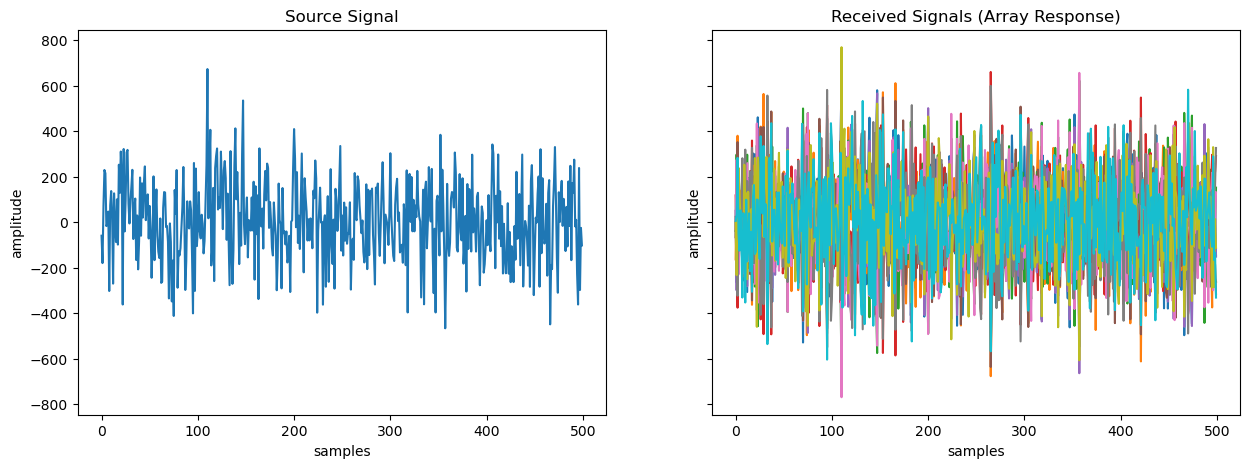

In [107]:
_, ax = plt.subplots(1, 2, figsize=(15, 5), sharey=True)
source_num = 2
plot_samples = 500

ax[0].plot(F[source_num, :plot_samples].real);
ax[0].set_title("Source Signal")
ax[0].set_xlabel("samples")
ax[0].set_ylabel("amplitude");


for i in range(X.shape[0]):
    ax[1].plot(X[i, :plot_samples].real)
ax[1].set_title("Received Signals (Array Response)")
ax[1].set_xlabel("samples")
ax[1].set_ylabel("amplitude");

In [108]:
Rxx = (X @ np.conj(X).T) / X.shape[1]
Rxx_inv = np.linalg.pinv(Rxx + 1e-6*np.eye(Rxx.shape[0]))
Rxx.shape, Rxx_inv.shape

((10, 10), (10, 10))

## Implement the Beamformers

In [115]:
# collection angles to process
thetas = np.arange(-90, 90 + 0.1, 0.1)

outputs = {"bartlett" : [], "capon" : []}
responses = {"bartlett" : [], "capon" : []}
for _theta in thetas:
    _theta *= np.pi/180
    v = steering_vector(_theta, M) # Steering Vector

    # Barlett Beamformer
    pb = np.conj(v)[:, None].T @ Rxx @ v
    wb = v / M # use normalized steering vector

    # Capon Beamformer
    pc = 1/(np.conj(v)[:, None].T @ Rxx_inv @ v)
    # pc = np.reciprocal(np.einsum('ij,i->j', np.c_[v].conj(), (Rxx_inv @ v.T)))
    wc = (Rxx_inv @ v)[:, None] * pc
    
    # optional: estimate the actual signal
    yb = (wb.conj().T @ X)
    yc = (wc.conj().T @ X)

    # append to lists
    outputs["bartlett"].append(yb.squeeze())
    outputs["capon"].append(yc.squeeze())

    # this produces voltage responses ? half power is 6dB here?
    # responses["bartlett"].append(10*np.log10(np.abs(pb)))
    # responses["capon"].append(10*np.log10(np.abs(pc)))

    # this seems to be power?? (10log10(x^0.5) = 5log10(x))
    responses["bartlett"].append(5*np.log10(np.abs(pb)))
    responses["capon"].append(5*np.log10(np.abs(pc)))

# normalize
responses["bartlett"] -= np.max(responses["bartlett"]) 
responses["capon"] -= np.max(responses["capon"]) 

# obtain angle that gave us the max value
angle_idx_b = np.argmax(responses["bartlett"])
aoa_b = thetas[angle_idx_b]
s_hat_b = outputs["bartlett"][angle_idx_b]

angle_idx_c = np.argmax(responses["capon"])
aoa_c = thetas[angle_idx_c]
s_hat_c = outputs["capon"][angle_idx_c]

In [116]:
aoa_b, aoa_c

(29.79999999999319, 29.99999999999318)

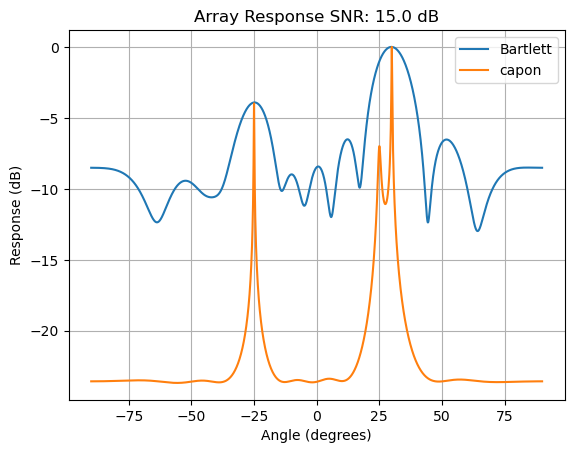

In [117]:
plt.plot(thetas, responses["bartlett"], label="Bartlett")
# plt.scatter([aoa_b], [np.max(responses["bartlett"])])
plt.plot(thetas, responses["capon"], label="capon")
# plt.scatter([aoa_c], [np.max(responses["capon"])])
plt.grid();
plt.legend();
plt.title(f"Array Response SNR: {SNR} dB")
plt.xlabel("Angle (degrees)")
plt.ylabel("Response (dB)");

# plt.ylim(-10, 1);

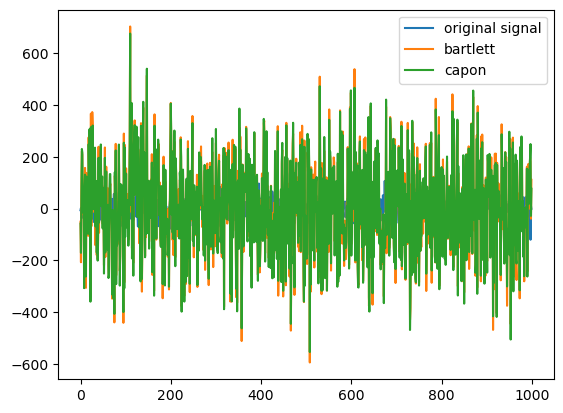

In [112]:
plt.plot(F[1, :].real[:1000], label="original signal");
plt.plot(outputs["bartlett"][angle_idx_b].real[:1000], label="bartlett");
plt.plot(outputs["capon"][angle_idx_c].real[:1000], label="capon");
plt.legend();

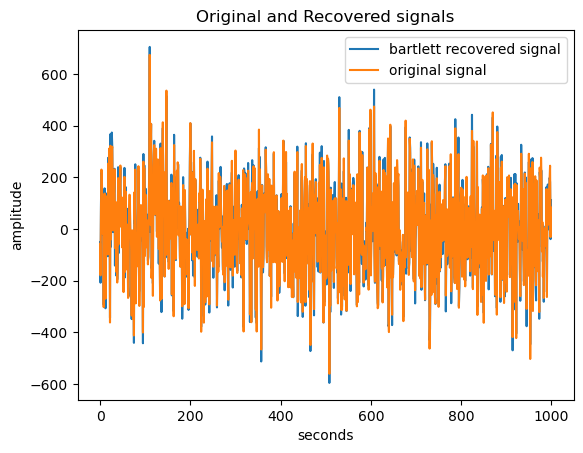

In [113]:
plt.plot(outputs["bartlett"][angle_idx_b].real[:1000], label="bartlett recovered signal");
plt.plot(F[2, :1000].real, label="original signal");

plt.title("Original and Recovered signals")
plt.xlabel("seconds")
plt.ylabel("amplitude");
plt.legend();

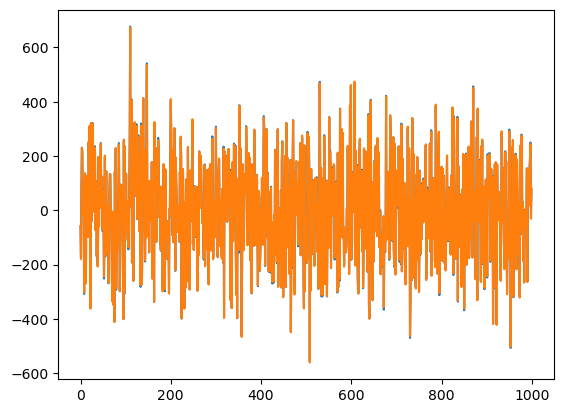

In [114]:
plt.plot(outputs["capon"][angle_idx_c].real[:1000], label="capon");
plt.plot(F[2, :1000].real, label="original signal");

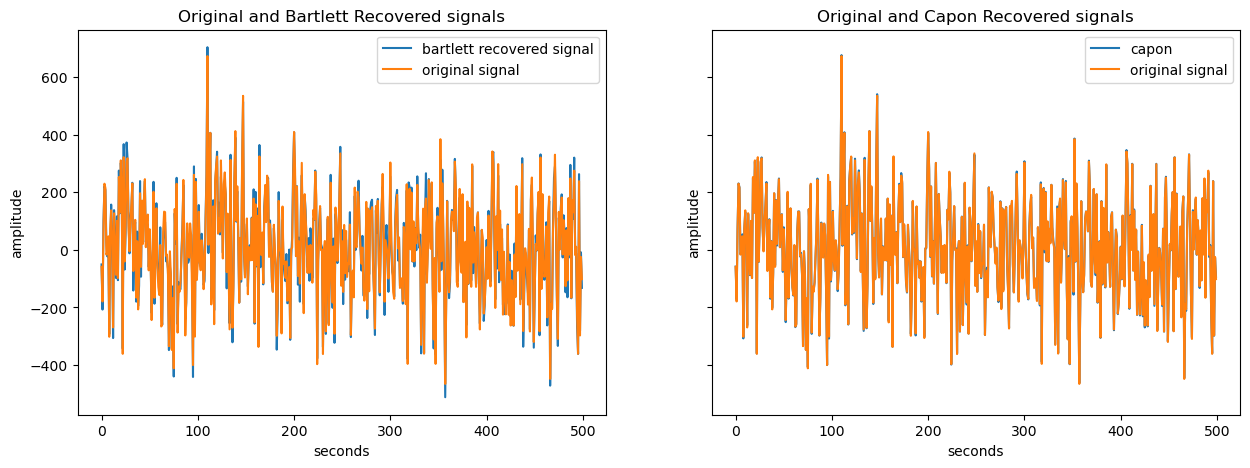

In [121]:
_, ax = plt.subplots(1, 2, figsize=(15, 5), sharey=True)
source_num = 2
plot_samples = 500

ax[0].plot(outputs["bartlett"][angle_idx_b].real[:plot_samples], label="bartlett recovered signal");
ax[0].plot(F[source_num, :plot_samples].real, label="original signal");
ax[0].set_title("Original and Bartlett Recovered signals")
ax[0].set_xlabel("seconds")
ax[0].set_ylabel("amplitude");
ax[0].legend();

ax[1].plot(outputs["capon"][angle_idx_c].real[:plot_samples], label="capon");
ax[1].plot(F[source_num, :plot_samples].real, label="original signal");
ax[1].set_title("Original and Capon Recovered signals")
ax[1].set_xlabel("seconds")
ax[1].set_ylabel("amplitude");
ax[1].legend();

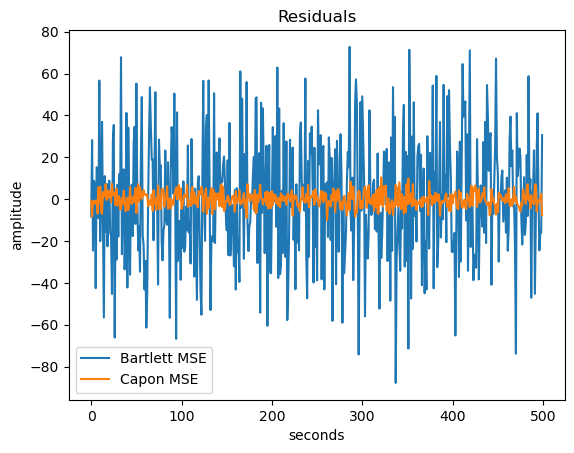

In [137]:
source_num = 2
plot_samples = 500

bartlett_res = F[source_num, :plot_samples].real - outputs["bartlett"][angle_idx_b].real[:plot_samples]
bartlett_mse = np.square(bartlett_res - bartlett_res.mean())
bartlett_mse = np.mean((bartlett_res)**2)

capon_res = F[source_num, :plot_samples].real - outputs["capon"][angle_idx_c].real[:plot_samples]
capon_mse = np.mean((capon_res)**2)

plt.plot(bartlett_res, label="Bartlett MSE");
plt.plot(capon_res, label="Capon MSE");

plt.title("Residuals")
plt.xlabel("seconds")
plt.ylabel("amplitude");
plt.legend();

In [138]:
bartlett_mse, capon_mse

(856.8309654845407, 13.906399082018092)